### GP Fitting
Author: Allen Ross  
Date: 5/18/21  

In [2]:
## Setup
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable

In [18]:
# Prediction function
def gp_predict_fun(gp, X, x_min, x_max, x_idx, unit_idx, unit_label, num_funs=10):    
    # Create test points
    x_new = np.zeros_like(X)
    x_new[:,x_idx] = np.linspace(x_min, x_max, X.shape[0])
    x_new[:, unit_idx] = unit_label

    # Predict mean and variance on new data
    mean, var = gp.predict_f(x_new)

    # Pull some posterior functions
    tf.random.set_seed(1) 
    samples = gp.predict_f_samples(x_new, num_funs) 

    # Generate plot
    p = plt.figure(figsize=(12, 6))
    p = sns.scatterplot(x=X[:,x_idx],
                    y=Y.flatten(),
                    hue=X[:,unit_idx].astype(int).astype(str),
                        legend=False)
    p = sns.lineplot(x=x_new[:,x_idx],
                 y=mean.numpy().flatten(),
                 linewidth=2,
                    color='darkgreen')
    
#     plt.plot(X[:,idx], Y, "kx", mew=2)
#     plt.plot(x_new[:,idx], mean, "C0", lw=2)
    p.fill_between(
        x_new[:, x_idx],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#         color="C0",
        color='lightgreen',
        alpha=0.5,
    )
    p.plot(x_new[:,x_idx], 
           samples[:, :, 0].numpy().T,# "C0", 
           color='dimgray',
           linewidth=0.5)

def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

In [19]:
# Read data in
df = pd.read_csv('simulated_data.csv')
X = df[['unit', 'treatment', 'time']].to_numpy().reshape(-1,3)
Y = df[['k1_obs']].to_numpy().reshape(-1,1)

In [20]:
df.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,0.0,0.85,1.41,0.54,40.94
1,0.0,0.0,1.4,1.12,0.68,1.42,42.18
2,0.0,0.0,2.0,1.18,0.91,1.68,42.72
3,0.0,0.0,2.4,1.12,0.95,2.12,43.10
4,0.0,0.0,3.4,0.45,0.31,2.80,43.44


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.17392  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.747315 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.453631 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

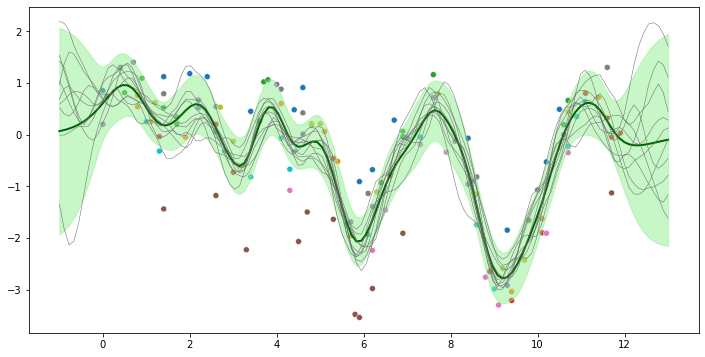

In [21]:
k = gpflow.kernels.Matern52(active_dims=[2])
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.5686871712696255   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9229873107491471   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[1].W            │ Pa

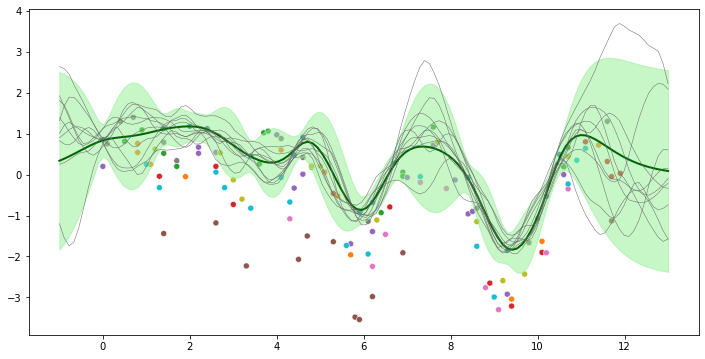

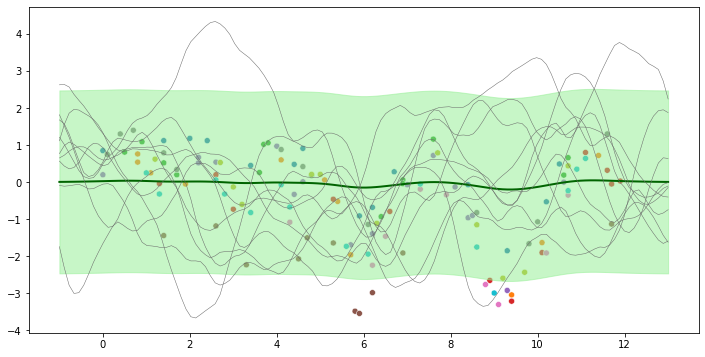

In [105]:
# k = gpflow.kernels.Matern52(active_dims=[2])
k = (gpflow.kernels.Matern52(active_dims=[2]) * 
    gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,0]))+1,
                            rank=1,active_dims=[0]))
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[1], False)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=10)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.mean_function.A     │ Parameter │ Identity         │         │ True        │ (3, 1)  │ float64 │ [[-0.06599628]     │
│                         │           │                  │         │             │         │         │  [-0.13357111]     │
│                         │           │                  │         │             │         │         │  [-0.10619759]]    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.mean_function.b     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.59575065]       │
├───────

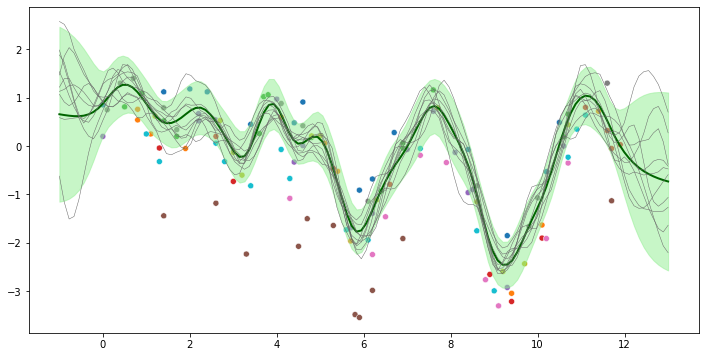

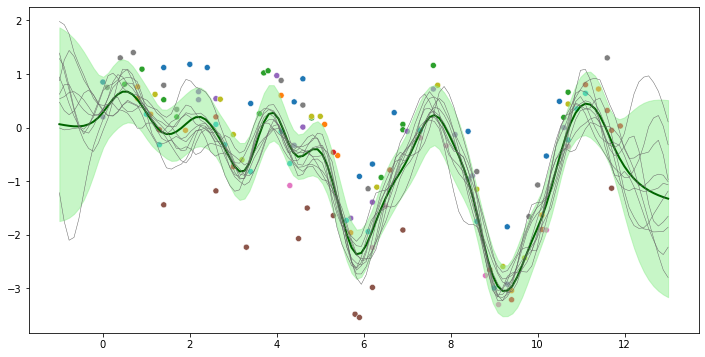

In [102]:
k = (gpflow.kernels.Matern52(active_dims=[2]))# * 
#     gpflow.kernels.Coregion(output_dim=len(np.unique(X[:,0])),
#                             rank=1,active_dims=[0]))
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=gpflow.mean_functions.Linear(A=np.zeros((3,1))))
# set_trainable(m.kernel.kernels[1], False)
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=9)
print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
               n=X.shape[0],
               k=len(m.trainable_parameters))
print(f'BIC: {bic}')

Now we need to specify the kernels we want to test

In [113]:
# Kernel search helper functions
def kernel_test(X, Y, k, no_tune=None):
    """
    This function evaluates a particular kernel selection on a set of data. 
    Inputs:
    
    """
    # Specify model
    m = gpflow.models.GPR(data=(X, Y),
                          kernel=k,
                          mean_function=None)
    # Check if some parameters shouldn't be trained
    if no_tune:
        for p in no_tune:
            set_trainable(m.kernel.kernels[p], False)
            
    gpflow.optimizers.Scipy().minimize(m.training_loss,
                                       m.trainable_variables)
    gp_predict_fun(gp=m, X=X, x_min=-1, x_max=13, x_idx=2, unit_idx=0, unit_label=0)
    print(f'Log marginal likelihood: {m.log_marginal_likelihood().numpy()}')
    bic = calc_bic(loglik=m.log_marginal_likelihood().numpy(),
                   n=X.shape[0],
                   k=len(m.parameters))
    print(f'BIC: {bic}')
    
def coregion_freeze(k):
    if k.name == 'coregion':
        print('Found coregion kernel, freezing parameters.')
        set_trainable(k, False)

def coregion_search(kern_list):
    for k in kern_list:
        if hasattr(k, 'kernels'):
            coregion_search(k.kernels)
        else:
            coregion_freeze(k)

Log marginal likelihood: -206.2202528693262
BIC: 422.1130695525554
Log marginal likelihood: -199.2374511227193
BIC: 408.1474660593416
Log marginal likelihood: -154.10668950708427
BIC: 322.72222473502296
Log marginal likelihood: -153.5966667507804
BIC: 321.7021792224152
Log marginal likelihood: -212.47872690427354
BIC: 434.63001762245005


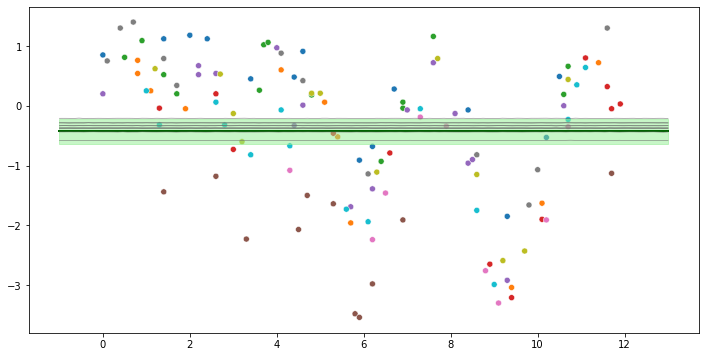

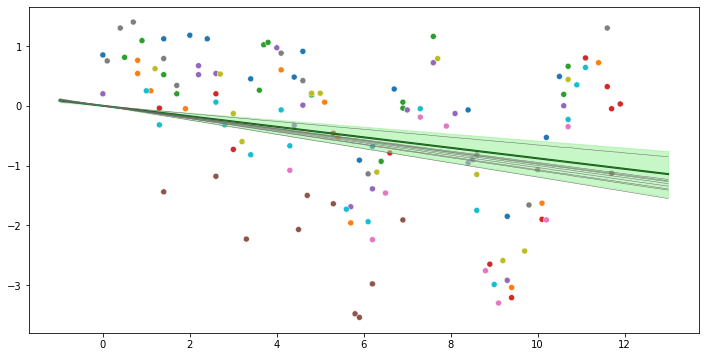

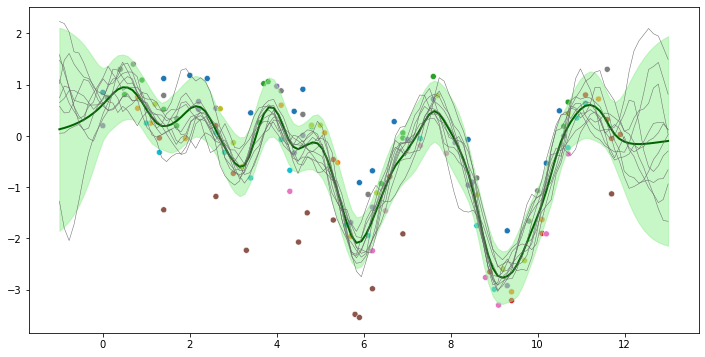

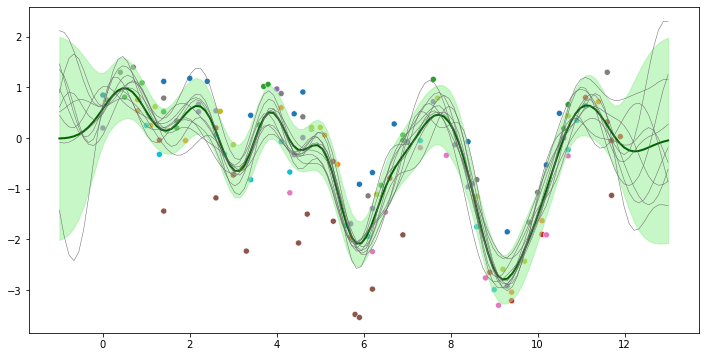

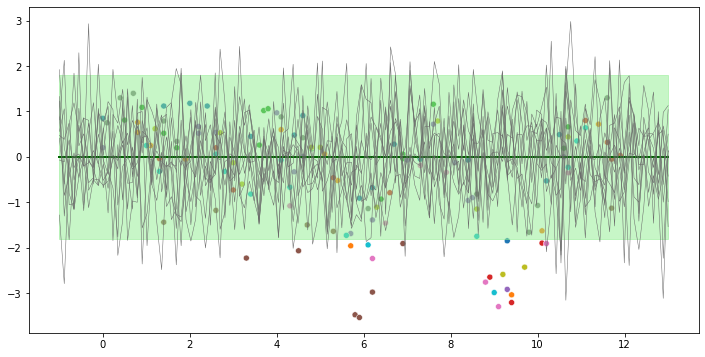

In [114]:
kernel_list = [gpflow.kernels.Constant(active_dims=[2]),
               gpflow.kernels.Linear(active_dims=[2]),
               gpflow.kernels.Matern32(active_dims=[2]),
               #gpflow.kernels.Periodic(),
               gpflow.kernels.SquaredExponential(active_dims=[2]),
               gpflow.kernels.White(active_dims=[2])]

# Loop through kernels for single dimension test first
for k in kernel_list:
    kernel_test(X, Y, k)

Found coregion kernel, freezing parameters.
Log marginal likelihood: -194.46458429929996
BIC: 408.27429622640585
Found coregion kernel, freezing parameters.
Log marginal likelihood: -187.47103645415697
BIC: 394.2872005361199
Found coregion kernel, freezing parameters.
Log marginal likelihood: -8.559914994484728
BIC: 41.30123952372685
Found coregion kernel, freezing parameters.
Log marginal likelihood: -13.161626305257357
BIC: 50.50466214527211
Found coregion kernel, freezing parameters.
Log marginal likelihood: -194.6831646655001
BIC: 408.71145695880614


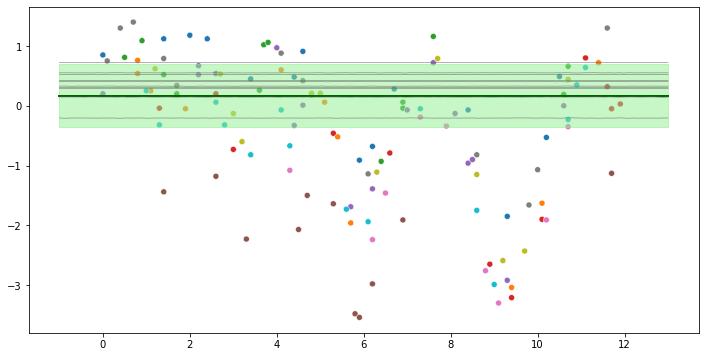

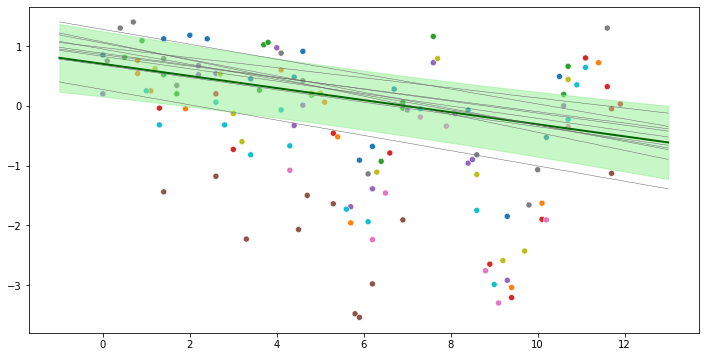

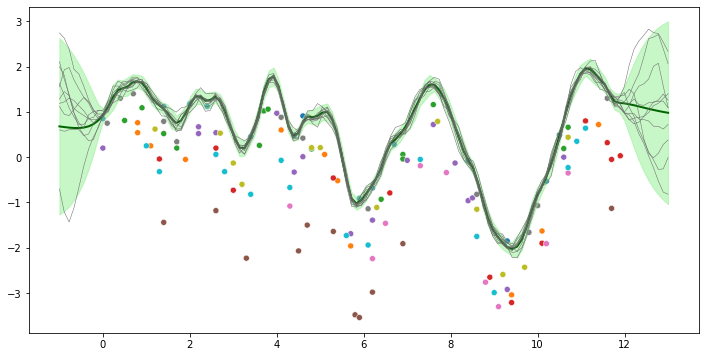

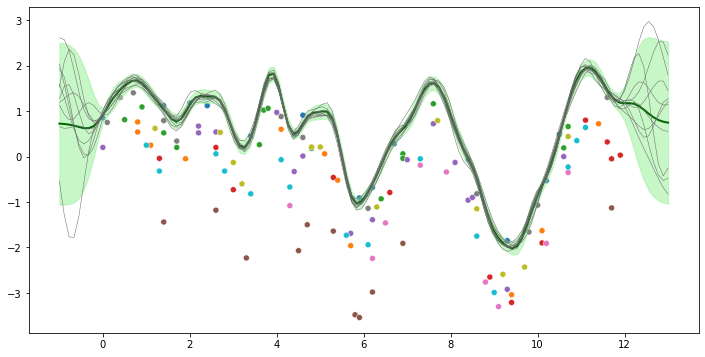

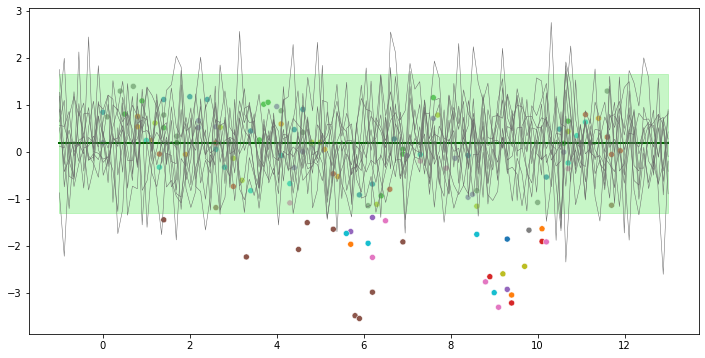

In [115]:
# Now try to add individual effects
for k in kernel_list:
    k = k + gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0])
    coregion_search(k.kernels)
    kernel_test(X, Y, k, no_tune=[1])

Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Log marginal likelihood: -194.68317177196877
BIC: 418.3840349856464
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Log marginal likelihood: -192.35615592548874
BIC: 413.7300032926863
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Log marginal likelihood: -152.89551956053126
BIC: 339.6450124697229
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Log marginal likelihood: -151.4815060164662
BIC: 336.81698538159276
Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.
Log marginal likelihood: -194.68316466550007
BIC: 418.384020772709


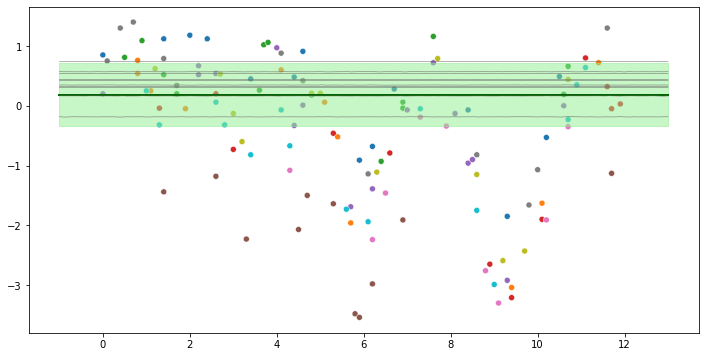

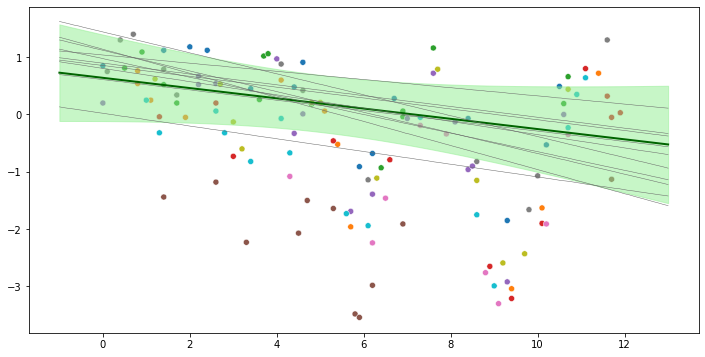

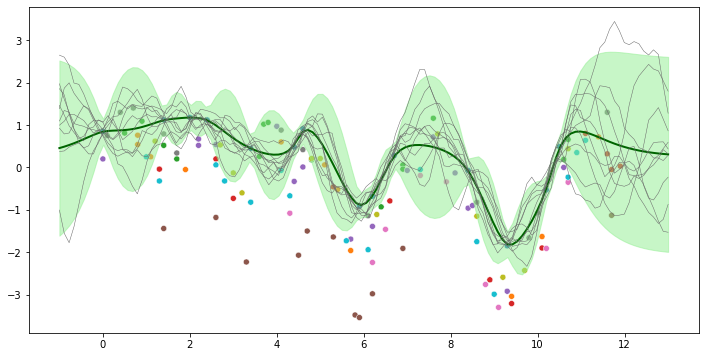

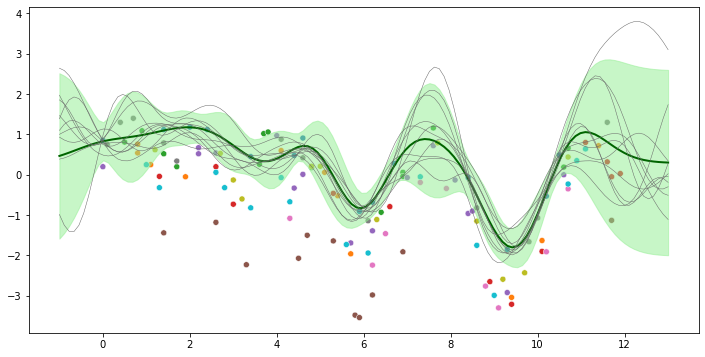

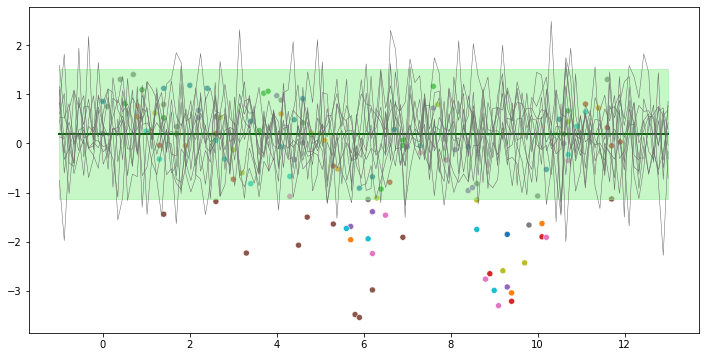

In [116]:
# Now try to add individual effects and individual slope effects
for k in kernel_list:
    k = (k * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]) + 
        gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]))
    coregion_search(k.kernels)
    kernel_test(X, Y, k)

In [97]:
m = gpflow.models.GPR(data=(X, Y),
                      kernel=(kernel_list[0] * gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0]) + 
        gpflow.kernels.Coregion(
                output_dim=len(np.unique(X[:,0])),
                rank=1,active_dims=[0])),
                      mean_function=None)

In [98]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.14799111513145632
GPR.kernel.kernels[0].kernels[1].W,Parameter,Identity,,True,"(10, 1)",float64,[[0.1...
GPR.kernel.kernels[0].kernels[1].kappa,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[1].W,Parameter,Identity,,True,"(10, 1)",float64,[[0.1...
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [87]:
for k in m.kernel.kernels:
    if hasattr(k,'kernels'):
        print(k.kernels)
        for k2 in k.kernels:
            if k2.name=='coregion':
                print(f'Found coregion kernel!')
                set_trainable(k2, False)
    else:
        print(k)
        if k.name=='coregion':
            print(f'Found coregion kernel!')
            set_trainable(k, False)

ListWrapper([<gpflow.kernels.statics.Constant object at 0x7fceafe15a60>, <gpflow.kernels.misc.Coregion object at 0x7fcead6bd100>])
Found coregion kernel!
Found coregion kernel!


In [99]:
def coregion_freeze(k):
    if k.name == 'coregion':
        print('Found coregion kernel, freezing parameters.')
        set_trainable(k, False)

def coregion_search(kern_list):
    for k in kern_list:
        if hasattr(k, 'kernels'):
            coregion_search(k.kernels)
        else:
            coregion_freeze(k)
            
coregion_search(m.kernel.kernels)

Found coregion kernel, freezing parameters.
Found coregion kernel, freezing parameters.


In [100]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.14799111513145632
GPR.kernel.kernels[0].kernels[1].W,Parameter,Identity,,False,"(10, 1)",float64,[[0.1...
GPR.kernel.kernels[0].kernels[1].kappa,Parameter,Softplus,,False,"(10,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[1].W,Parameter,Identity,,False,"(10, 1)",float64,[[0.1...
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,False,"(10,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
